# Clasificación de semillas de trigo por medio redes neuronales usando Keras

<div style="display: flex; justify-content: space-evenly; align-items: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Vehn%C3%A4pelto_6.jpg/640px-Vehn%C3%A4pelto_6.jpg" />
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Keras_logo.svg/480px-Keras_logo.svg.png" width="300" height="300" />
</div>

Se creará una red neuronal para predecir la especie de una semilla de trigo basándonos en sus características. Usaremos el conjunto de datos de semillas de trigo de Instituto de Agrofísica de la Academia de Ciencias de Polonia en Lublin.

Este conjunto de datos contiene 210 muestras de semillas de trigo de tres especies diferentes: Kama, Rosa y Canadian. 

Cada muestra tiene 7 características que serían las entradas de la red: área, perímetro, compactness, longitud del kernel, ancho del kernel, asimetría del kernel y longitud del grano del kernel. 

La especie de la semilla sería la salida de la red.

Como herramienta se usará `Keras`, una librería de redes neuronales escrita en Python que corre sobre `TensorFlow`, dedicada a la experimentación rápida y fácil de redes neuronales.

In [76]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import requests
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

## Preparación de datos

Primero se descargan los datos y se cargan en un `DataFrame` de `Pandas`, se le asigna un nombre a cada columna y se muestran los primeros 5 registros.


### Descarga de datos

In [77]:
def download_csv_and_save(url, filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)

download_csv_and_save("https://cdn.discordapp.com/attachments/982420060457009235/1028508970513604719/seeds_dataset.csv", "seeds_dataset.csv")

### Nombre de las columnas

In [78]:
columns = ["Area", "Perimeter", "Compatibility", "Core length", "Core width", "Asymmetry coefficient", "Grain furrow length", "Label"]

### Lectura de datos

In [97]:
df = pd.read_csv("seeds_dataset.csv", header=None, names=columns)
df.head()

,Area,Perimeter,Compatibility,Core length,Core width,Asymmetry coefficient,Grain furrow length,Label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


### Normalización de datos

Se usa la función `MinMaxScaler` de `sklearn` para normalizar los datos de entrada entre 0 y 1.

In [80]:
def normalize_data(data):
    """Normalizes the data between 0 and 1"""
    min_max_scaler = preprocessing.MinMaxScaler()
    data = min_max_scaler.fit_transform(data)
    return pd.DataFrame(data, columns=columns)

### División de las entradas y salidas

In [81]:
def split_features_and_labels(df):
    """Splits the features and labels"""
    features = df.drop("Label", axis=1, inplace=False)
    labels = df["Label"]
    return features, labels

features, labels = split_features_and_labels(df)

### Conversión de las salidas a one-hot encoding

Ya que las salidas son categóricas, se usa la función `to_categorical` de `keras.utils` para convertirlas a one-hot encoding. Esta técnica consiste en convertir una variable categórica en un vector de 0s y 1s. Por ejemplo, si tenemos 3 categorías, la categoría 1 se convertiría en `[1, 0, 0]`, la categoría 2 en `[0, 1, 0]` y la categoría 3 en `[0, 0, 1]`.

**Nota**: en este proceso tuvimos un problema: al usar esta función, nos regresó 4 columnas en lugar de 3. Esto se debe a que la función `to_categorical` toma como entrada el número de categorías, y como tenemos 3 categorías, la función pensó que la categoría 0 no existía. 

Para solucionar esto, se eliminó la primera columna de la matriz de salidas.

In [82]:
labels = to_categorical(labels.values)
labels = pd.DataFrame(labels, columns=["?", "Kama", "Rosa", "Canadian"])
labels = labels.drop("?", axis=1, inplace=False)

### División de los datos en entrenamiento y prueba

Se usó la función `train_test_split` de `sklearn` para dividir los datos en 2 conjuntos: entrenamiento y prueba. El conjunto de entrenamiento se usará para entrenar la red neuronal, y el conjunto de prueba se usará para evaluar el desempeño de la red.

Igualmente se especificó que el 70% de los datos se usará para entrenamiento y el 30% para prueba. Además que se especificó que los datos se dividieran de forma aleatoria, ya que inicialmente el conjunto de datos está ordenado por especie.


In [83]:
train, test, train_labels, test_labels = train_test_split(features, labels,  shuffle=True, train_size=0.7)

Al hacer la división de los datos, los indices de las filas se mezclaron, por lo que se tuvo que reordenar los datos de entrada y salida para que coincidieran.

In [84]:
test.index = test_labels.index = np.arange(0, len(test))

## Creación y entrenamiento de la red neuronal

### Creación del modelo

Se creó un modelo secuencial, que es una pila lineal de capas. La configuración inicial que se pensó fue la siguiente:

- Capa de entrada con 64 neuronas, cada una conectada al input de 7 características. Se usa la función de activación `relu` para las neuronas de la capa de entrada.
- Capa oculta con 64 neuronas. También se usa la función de activación `relu`.
- Capa de salida con 3 neuronas, una por cada categoría. Se usa la función de activación `softmax` para la capa de salida.

La función de activación `relu` es posiblemente la más usada en capas ocultas. Se usa para evitar que los valores de las neuronas se vuelvan negativos, lo que podría causar problemas en la red.

<p align="center">
  <img src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2021/11/ReLU-activation-function.png" />
</p>

La función de activación `softmax` es una función de activación que se usa para clasificación. Su función es convertir los valores de las neuronas de la capa de salida en probabilidades. Por ejemplo, si tenemos 3 categorías, la neurona 1 tendrá una probabilidad de que la semilla sea de la categoría 1, la neurona 2 tendrá una probabilidad de que la semilla sea de la categoría 2 y la neurona 3 tendrá una probabilidad de que la semilla sea de la categoría 3.

<p align="center">
  <img src="https://www.researchgate.net/publication/319121953/figure/fig2/AS:527474636398592@1502771161390/Softmax-activation-function.png" />
  </p> 

In [85]:
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(7,)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

### Compilación del modelo

Se compiló el modelo con la función `compile` de `keras`. Se especificó que se usaría la función de pérdida o error `categorical_crossentropy`, que es una función de pérdida que se usa para clasificación. También se especificó que se usaría el optimizador `adam`, que es un optimizador que se usa para redes neuronales.

Los optimizadores son funciones que implementan los algoritmos de `backpropagation` y `gradient descent` para entrenar la red neuronal.

Hay diferentes tipos de optimizadores, y cada uno tiene sus ventajas y desventajas. El optimizador `adam` es uno de los más usados, y es el que se usó en este proyecto.

In [86]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

### Entrenamiento del modelo

Se entrenó el modelo con la función `fit` de `keras`. Se especificó que se usarían 50 épocas, que es el número de veces que se entrenará la red con el conjunto de entrenamiento. También se especificó que se usaría un tamaño de lote de 10, que es el número de muestras que se usarán para entrenar la red en cada época. Estos lotes se llaman `mini-batches` y es una técnica usada para optimizar el entrenamiento de la red.

In [87]:
history = model.fit(train, train_labels, epochs=50, batch_size=32, validation_data=(test, test_labels))

Epoch 1/50
5/5 [==============================] - 1s 43ms/step - loss: 2.1766 - accuracy: 0.3401 - val_loss: 1.1433 - val_accuracy: 0.3175
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.2361 - accuracy: 0.3469 - val_loss: 1.2790 - val_accuracy: 0.4127
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 1.2060 - accuracy: 0.5306 - val_loss: 1.0012 - val_accuracy: 0.5873
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.9665 - accuracy: 0.4626 - val_loss: 0.9297 - val_accuracy: 0.3333
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 0.9229 - accuracy: 0.4082 - val_loss: 0.8770 - val_accuracy: 0.6032
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8706 - accuracy: 0.6327 - val_loss: 0.8017 - val_accuracy: 0.6984
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.8077 - accuracy: 0.7143 - val_loss: 0.7644 - val_accuracy: 0.6825
Epoch 8/50
5/5 [=================

## Evaluación del modelo

Aquí se evalúa el desempeño de la red neuronal. Se usa la función `evaluate` de `keras` para evaluar el modelo con el conjunto de prueba. Esta función regresa el valor de la función de pérdida y la precisión del modelo.

In [88]:
test_loss, test_acc = model.evaluate(test, test_labels)

2/2 [==============================] - 0s 3ms/step - loss: 0.2941 - accuracy: 0.9048


## Predicción

Se usó la función `predict` de `keras` para predecir la categoría de una semilla. Para facilidar este trabajo, se definió una función que recibe como parámetros las características de la semilla y regresa la categoría a la que pertenece.

In [89]:
def predict(*indices):
    """Predicts the label of a given index"""
    class_names = ["Kama", "Rosa", "Canadian"]
    for index in indices:
        prediction = model.predict(test.loc[index:index].values.reshape(1, 7))
        print("Prediction: ", class_names[np.argmax(prediction)], " | Actual: ", class_names[np.argmax(test_labels.loc[index].values)])

Se usó la semilla 1 del conjunto de prueba para hacer la predicción. La función regresa un vector de 3 elementos, cada uno con una probabilidad de que la semilla sea de la categoría 1, 2 o 3. La categoría con la probabilidad más alta es la categoría de la semilla.

Se puede ver que para la semilla 1, su categoría esperada es Rosa.

In [90]:
test_labels.loc[0]

Kama        0.0
Rosa        1.0
Canadian    0.0
Name: 0, dtype: float32

Al iniciar la predicción, se puede ver que la categoría predicha es Rosa, lo que significa que la red neuronal predijo correctamente la categoría de la semilla.

In [91]:
predict(1)

1/1 [==============================] - 0s 44ms/step
Prediction:  Kama  | Actual:  Kama


También podemos predecir los primeros 10 elementos del conjunto de prueba. Se puede ver que la red neuronal predijo correctamente todas las categorías.

In [92]:
predict(*range(10))

1/1 [==============================] - 0s 17ms/step
Prediction:  Rosa  | Actual:  Rosa
1/1 [==============================] - 0s 16ms/step
Prediction:  Kama  | Actual:  Kama
1/1 [==============================] - 0s 18ms/step
Prediction:  Rosa  | Actual:  Rosa
1/1 [==============================] - 0s 20ms/step
Prediction:  Kama  | Actual:  Canadian
1/1 [==============================] - 0s 24ms/step
Prediction:  Canadian  | Actual:  Kama
1/1 [==============================] - 0s 17ms/step
Prediction:  Canadian  | Actual:  Canadian
1/1 [==============================] - 0s 21ms/step
Prediction:  Canadian  | Actual:  Canadian
1/1 [==============================] - 0s 24ms/step
Prediction:  Kama  | Actual:  Kama
1/1 [==============================] - 0s 23ms/step
Prediction:  Kama  | Actual:  Kama
1/1 [==============================] - 0s 28ms/step
Prediction:  Canadian  | Actual:  Canadian


### Predicciones totales

Aunque podemos ver que la red neuronal no predijo correctamente todas las categorías, se puede ver que la precisión del modelo en promedio es de 0.95, lo que significa que el modelo predijo correctamente el 95% de las categorías.

In [93]:
predictions = model.predict(test)

print("Predicciones en la categoría Kama: ", len(list(filter(lambda x: np.argmax(x) == 0, predictions))))
print("Predicciones en la categoría Rosa: ", len(list(filter(lambda x: np.argmax(x) == 1, predictions))))
print("Predicciones en la categoría Canadian: ", len(list(filter(lambda x: np.argmax(x) == 2, predictions))))

2/2 [==============================] - 0s 2ms/step
Predicciones en la categoría Kama:  22
Predicciones en la categoría Rosa:  19
Predicciones en la categoría Canadian:  22


In [94]:
pd.DataFrame(test_labels.value_counts().values, index=["Kama", "Rosa", "Canadian"], columns=["Cantidad de datos en el conjunto de test"])

,Cantidad de datos en el conjunto de test
Kama,22
Rosa,21
Canadian,20


## Gráficas de de error y precisión

Aquí se muestran las gráficas de error y precisión del modelo. Se puede ver que el error disminuye a medida que aumenta el número de épocas, lo que significa que el modelo se está entrenando correctamente. También se puede ver que la precisión aumenta, lo que significa que el modelo está aprendiendo correctamente.

### Error

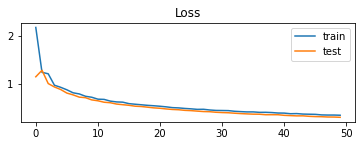

In [95]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

### Precisión

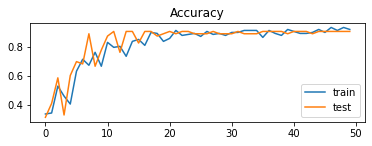

In [96]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

# Clasificación de semillas usando una arquitectura 7:12:8:1

Ya que el procesamiento de datos usado en el ejercicio anterior fue dirigido a una salida de 3 categorias, no podemos usarlo para una capa de salida de una sola neurona. Por ende, se debe realizar un nuevo procesamiento de datos.